# Introduction
This tutorial demostrates step-by-step instructions to perform inference on a PyTorch model using [OpenVINO](https://github.com/openvinotoolkit/openvino)

The PyTorch model is converted to ONNX and loaded with OpenVINO. The model is pretrained on [CityScapes](https://www.cityscapes-dataset.com)

# Notebook

The RHODS notebook images do not yet include the python widgets extension. The commands below will install and activate them. 

In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

You should consider upgrading via the '/opt/app-root/bin/python3.6 -m pip install --upgrade pip' command.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


After the command above completes, the notebook kernel should be restarted. This can be done from the Kernel menu, by selecting "Restart Kernel"

# Settings

In [2]:
# Path to the Model Optimizer ONNX file. The full path to `mo_onnx.py` 
mo_path = r'/opt/app-root/lib/python3.6/site-packages/mo.py'

# The filenames of the downloaded and converted models
base_model_name = 'fastseg'
model_fname = base_model_name + '.pth'
onnx_fname = base_model_name + '.onnx'
ir_fname = base_model_name + '.xml'

# Install OpenVINO



Pin the OpenCV version because later versions will require notebook images that include the libGL shared library.

In [3]:
!pip install opencv-python-headless==4.2.0.32

You should consider upgrading via the '/opt/app-root/bin/python3.6 -m pip install --upgrade pip' command.


In [4]:
!pip install --quiet --index-url https://test.pypi.org/simple --extra-index-url https://pypi.org/simple openvino-dev 

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tf-nightly 2.5.0.dev20210316 requires numpy~=1.19.2, but you'll have numpy 1.16.6 which is incompatible.
tensorflow 2.4.1 requires gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
tensorflow 2.4.1 requires h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
tensorflow 2.4.1 requires numpy~=1.19.2, but you'll have numpy 1.16.6 which is incompatible.
intel-tensorflow-avx512 2.4.0 requires gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
intel-tensorflow-avx512 2.4.0 requires grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
intel-tensorflow-avx512

# Install required Python packages

Download and Install the required packages for this demo. If you use OSX, change this cell to use the command to install PyTorch for OSX.

In [5]:
# Windows and Linux
# !pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.5.1 torchvision==0.6.1 -f https://download.pytorch.org/whl/torch_stable.html

# OSX
# pip install torch==1.5.1 torchvision==0.6.1

!pip install -U --quiet geffnet==0.9.8 fastseg onnx numpy==1.18.5

Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/opt/app-root/bin/python3.6 -m pip install --upgrade pip' command.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tf-nightly 2.5.0.dev20210316 requires numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
tensorflow 2.4.1 requires gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
tensorflow 2.4.1 requires h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
tensorflow 2.4.1 requires numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
openvino-dev 2021.3.0 requires numpy==1.16.6, but you'll h

# OpenVINO PyTorch Demo - Image Segmentation with Fastseg

### Import the PyTorch Library and Fastseg

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch

from fastseg import MobileV3Large

import shutil
import subprocess

### Download the Fastseg Model

This downloads and loads the model and pretrained weights. It may take some time.

In [8]:
print("Downloading the Fastseg model (if it has not been downloaded before)....")
model = MobileV3Large.from_pretrained().cpu().eval()
model.eval()
print("Loaded PyTorch Fastseg model")

# Save the model
if not os.path.exists(model_fname):
    print("\nSaving the model")
    torch.save(model.state_dict(), model_fname)
    print(f"Model saved at {model_fname}")

Loading pretrained model mobilev3large-lraspp with F=128...
Loaded PyTorch Fastseg model


### Create ONNX model

In [9]:
if not os.path.exists(onnx_fname):
    dummy_input = torch.randn(1, 3, 512, 1024)
    torch.onnx.export(model, dummy_input, onnx_fname, opset_version=11)
    print(f'ONNX model exported to {onnx_fname}.')
else:
    print(f'ONNX model {onnx_fname} already exists.')

ONNX model fastseg.onnx already exists.


### Convert the Model to IR

In [10]:
if not os.path.exists(ir_fname):
    print('Exporting ONNX model to IR...')
    ! python $mo_path --input_model $onnx_fname --input_shape "[1,3, 512,1024]" --data_type FP16 --output_dir . --model_name $base_model_name
    print(f'ONNX model exported to IR model: {ir_fname}')
else:
    print(f'IR model {ir_fname} already exists.')

Exporting ONNX model to IR...
fatal: not a git repository (or any parent up to mount point /opt/app-root)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /opt/app-root)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /opt/app-root)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/opt/app-root/src/fastseg.onnx
	- Path for generated IR: 	/opt/app-root/src/.
	- IR output name: 	fastseg
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,3, 512,1024]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR

### Define Preprocessing and Display Functions

In [11]:
def normalize(image: np.ndarray) -> np.ndarray:
    """Normalize the image to the given mean and standard deviation for CityScapes models."""
    image = image.astype(np.float32)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    image /= 255.0
    image -= mean
    image /= std
    return image

def show_image_and_result(image:np.ndarray, result: np.ndarray):
    fig, ax = plt.subplots(1,2, figsize=(25,8))
    ax[0].imshow(image)
    ax[1].imshow(result)
    for a in ax:
        a.axis('off')

### Load and Pre-process an Input Image

---




In [12]:
!wget https://user-images.githubusercontent.com/3080674/29361099-52eb370c-8286-11e7-8274-ceb4895fe0b9.png -O street.png

--2021-03-17 14:23:36--  https://user-images.githubusercontent.com/3080674/29361099-52eb370c-8286-11e7-8274-ceb4895fe0b9.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2534434 (2.4M) [image/png]
Saving to: ‘street.png’

street.png          100%[===================>]   2.42M  --.-KB/s    in 0.02s   

2021-03-17 14:23:36 (128 MB/s) - ‘street.png’ saved [2534434/2534434]



In [13]:
image = cv2.cvtColor(cv2.imread("street.png"), cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (1024,512))
normalized_image = normalize(resized_image)
input_image = np.expand_dims(np.transpose(normalized_image, (2,0,1)), 0).astype(np.float32)  # Convert the image shape to shape expected by network
input_image_tensor = torch.as_tensor(input_image).float()

### Load the OpenVINO IR network and Run Inference on the ONNX model

Inference Engine can load ONNX models directly. We first load the ONNX model, do inference and show the results. After that we load the model that was converted to Intermediate Representation (IR) with Model Optimizer and do inference on that model and show the results.

#### 1. ONNX model in Inference Engine

In [14]:
from openvino.inference_engine import IECore

# Load network to the plugin
ie = IECore()
net_onnx = ie.read_network(model='fastseg.onnx')
exec_net_onnx = ie.load_network(network=net_onnx, device_name="CPU")

input_layer_onnx = next(iter(exec_net_onnx.input_info))
output_layer_onnx = next(iter(exec_net_onnx.outputs))

# Run the Inference on the Input image...
res_onnx = exec_net_onnx.infer(inputs={input_layer_onnx: input_image})
res_onnx = res_onnx[output_layer_onnx]

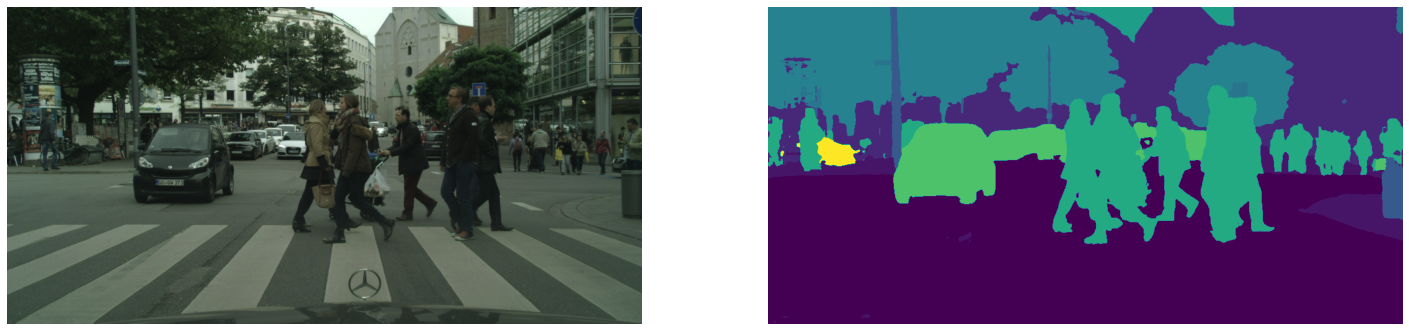

In [15]:
result_mask_onnx = np.squeeze(np.argmax(res_onnx, axis=1))
show_image_and_result(image, result_mask_onnx)

#### 2. IR model in Inference Engine

In [16]:
from openvino.inference_engine import IECore

# Load network to the plugin
ie = IECore()
net_ir = ie.read_network(model=ir_fname)
exec_net_ir = ie.load_network(network=net_ir, device_name="CPU")
del net_ir

input_layer_ir = next(iter(exec_net_ir.input_info))
output_layer_ir = next(iter(exec_net_ir.outputs))

# Run the Inference on the Input image...
res_ir = exec_net_ir.infer(inputs={input_layer_ir: input_image})
res_ir = res_ir[output_layer_ir]

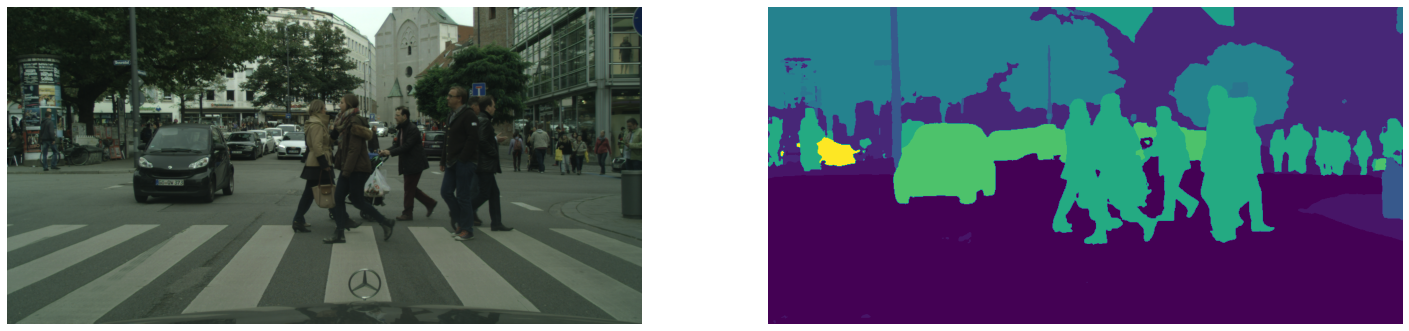

In [17]:
result_mask_ir = np.squeeze(np.argmax(res_ir, axis=1))
show_image_and_result(image, result_mask_ir)

## PyTorch Comparison

Do inference on the PyTorch model to verify that the output visually looks the same as the ONNX/IR models.

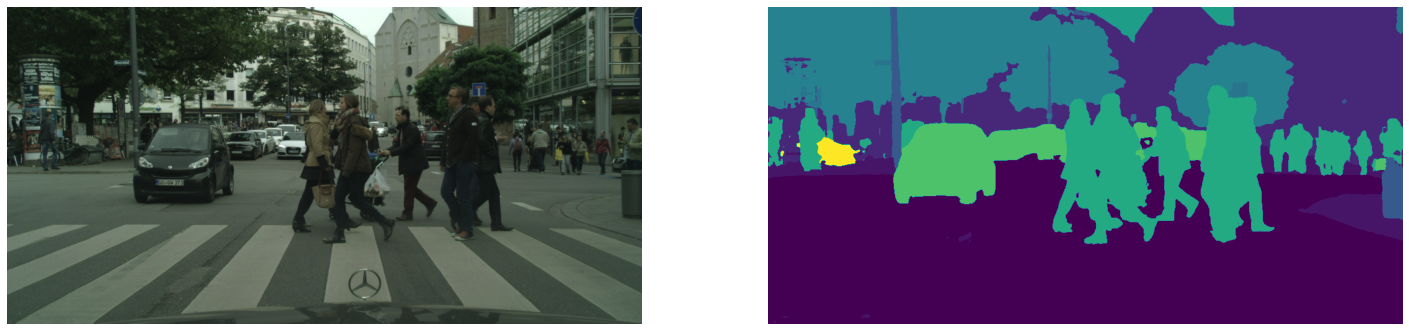

In [18]:
result_torch = model(input_image_tensor)
result_mask_torch = torch.argmax(result_torch, dim=1).squeeze(0)
show_image_and_result(image, result_mask_torch)

## Performance comparison

Measure the time it takes to do inference on five images on CPU. This gives an indication of performance. For more accurate benchmarking, use the [OpenVINO benchmark tool](https://github.com/openvinotoolkit/openvino/tree/master/inference-engine/tools/benchmark_tool). Note that many optimizations are possible to improve the performance. 

In [19]:
num_images = 10

start = time.perf_counter()
for _ in range(num_images):
    exec_net_onnx.infer(inputs={input_layer_onnx: input_image})
end = time.perf_counter()
time_onnx = end - start
print(f'ONNX model in Inference Engine/CPU: {time_onnx/num_images:.3f} seconds per image')

start = time.perf_counter()
for _ in range(num_images):
    exec_net_ir.infer(inputs={input_layer_ir: input_image})
end = time.perf_counter()
time_ir = end - start
print(f'IR model in Inference Engine/CPU: {time_ir/num_images:.3f} seconds per image')

start = time.perf_counter()
for _ in range(num_images):
    model(input_image_tensor)
end = time.perf_counter()
time_torch = end - start
print(f'PyTorch model on CPU: {time_torch/num_images:.3f} seconds per image')

ONNX model in Inference Engine/CPU: 0.118 seconds per image
IR model in Inference Engine/CPU: 0.119 seconds per image
PyTorch model on CPU: 1.828 seconds per image


# References

https://docs.openvinotoolkit.org/latest/openvino_docs_IE_DG_ONNX_Support.html